In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
partidos = pd.read_csv("games.csv")
apariciones = pd.read_csv("appearances.csv")
jugadores = pd.read_csv("players.csv")

In [3]:
#Solo jugadores activos en el año 2022
#Esta información necesitará actualización en el futuro :)

jugadores = jugadores[jugadores["last_season"] == 2022]

#Quitar juagdores sin valor de mercado 

jugadores = jugadores[jugadores.market_value_in_gbp.isnull() == False]

#Ordenar por valor de mercado

jugadores = jugadores.sort_values("market_value_in_gbp", ascending = False)

En la tabla de jugadores original no se incluyen las estadísticas de la temporada. Por esto se va a añadir la tabla de apariciones para crear algunas columnas nuevas relativas a las estadísticas clave de los jugadores de la temporada 2021/22.

In [4]:
games_and_apps = apariciones.merge(partidos, on=['game_id'], how='left')

def estadisticas_jugador(player_id, season, df):
    
    df = df[df['player_id'] == player_id]
    df = df[df['season'] == season]
    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet'])
        return out_df
    
    else:
        
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
                      else 0 if row['goals_against'] > 0
                      else np.nan, axis=1)
        
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum'})
        out_df = df.rename(columns={'game_id': 'games'})

        return out_df
    
    
season = 2021
for index in jugadores.index:
    id = jugadores.loc[index][0]
    name = jugadores.loc[index][1]
    stats = estadisticas_jugador(id, season, games_and_apps)
    jugadores.at[index,'goals_{}'.format(season)]= stats['goals'][0]
    jugadores.at[index,'games_{}'.format(season)]= stats['games'][0]
    jugadores.at[index,'assists_{}'.format(season)]= stats['assists'][0]
    jugadores.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
    jugadores.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
    jugadores.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
    jugadores.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]

In [5]:
#Se calcula la edad de los jugadores

jugadores['date_of_birth'] = pd.to_datetime(jugadores['date_of_birth'])

#Se quitan los jugadores sin fecha de nacimiento

jugadores = jugadores[jugadores['date_of_birth'].isnull() == False]

now = datetime.now()

jugadores['age'] = (now - jugadores['date_of_birth']).apply(lambda x: x.days) / 365.25
jugadores['age'] = jugadores['age'].round().astype(int)

In [7]:
jugadores.head(5)

,player_id,pretty_name,club_id,club_pretty_name,current_club_id,country_of_citizenship,country_of_birth,city_of_birth,date_of_birth,position,...,last_season,url,goals_2021,games_2021,assists_2021,minutes_played_2021,goals_for_2021,goals_against_2021,clean_sheet_2021,age
25264,342229,Kylian Mbappe,583,Fc Paris Saint Germain,583,France,France,Bondy,1998-12-20,Attack,...,2022,https://www.transfermarkt.co.uk/kylian-mbappe/...,34.0,43.0,25.0,3706.0,102.0,44.0,15.0,24
21673,418560,Erling Haaland,281,Manchester City,281,Norway,England,Leeds,2000-07-21,Attack,...,2022,https://www.transfermarkt.co.uk/erling-haaland...,29.0,31.0,8.0,2478.0,76.0,53.0,6.0,23
24194,371998,Vinicius Junior,418,Real Madrid,418,Brazil,Brazil,São Gonçalo,2000-07-12,Attack,...,2022,https://www.transfermarkt.co.uk/vinicius-junio...,22.0,52.0,20.0,4275.0,114.0,47.0,21.0,23
21814,406635,Phil Foden,281,Manchester City,281,England,England,Stockport,2000-05-28,Midfield,...,2022,https://www.transfermarkt.co.uk/phil-foden/pro...,13.0,42.0,9.0,2932.0,108.0,43.0,21.0,23
23605,581678,Jude Bellingham,16,Borussia Dortmund,16,England,England,Stourbridge,2003-06-29,Midfield,...,2022,https://www.transfermarkt.co.uk/jude-bellingha...,7.0,45.0,14.0,3886.0,104.0,70.0,12.0,20


In [9]:
jugadores.dtypes

player_id                               int64
pretty_name                            object
club_id                                 int64
club_pretty_name                       object
current_club_id                         int64
country_of_citizenship                 object
country_of_birth                       object
city_of_birth                          object
date_of_birth                  datetime64[ns]
position                               object
sub_position                           object
name                                   object
foot                                   object
height_in_cm                            int64
market_value_in_gbp                   float64
highest_market_value_in_gbp           float64
agent_name                             object
contract_expiration_date               object
domestic_competition_id                object
club_name                              object
image_url                              object
last_season                       

<Axes: xlabel='domestic_competition_id', ylabel='market_value_in_gbp'>

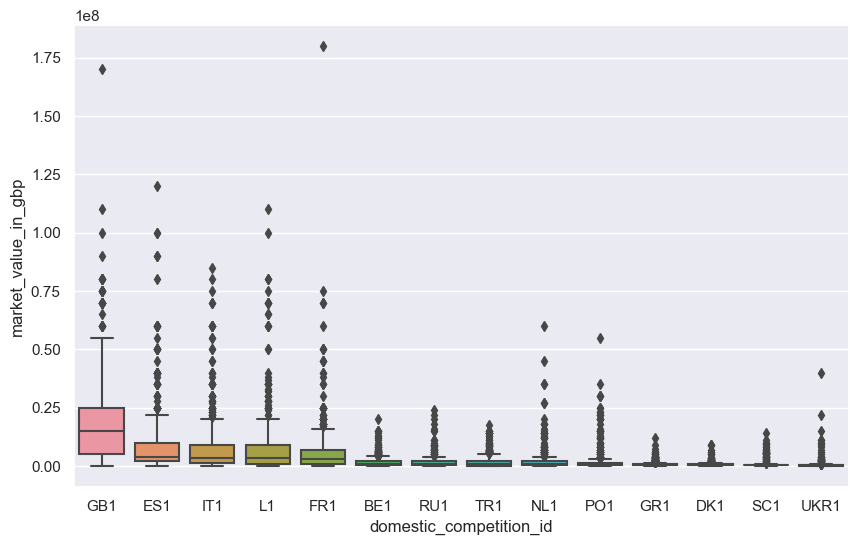

In [12]:
grupo = jugadores.loc[:,['domestic_competition_id', 'market_value_in_gbp']] \
    .groupby(['domestic_competition_id']) \
    .median() \
    .sort_values(by='market_value_in_gbp', ascending=False)

sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x=jugadores.domestic_competition_id, y=jugadores.market_value_in_gbp, order=grupo.index)

Valor de mercado por liga. 

Es posible que se reconozca a Kylian Mbappe, el jugador más valioso del fútbol con un  valor de 180 millones de libras.
No muy lejos de Mbappe, se encuentra con una valoración de mercado de 170 millones de libras, otro joven delantero Erling Haaland que es el segundo jugador más valioso que juega en la GB1 (Premier League) para el Manchester City.
En 2023, Mbappe y Halland serán los dos únicos jugadores que superarán los 150 millones de libras de valoración de mercado.

<Axes: xlabel='position', ylabel='market_value_in_gbp'>

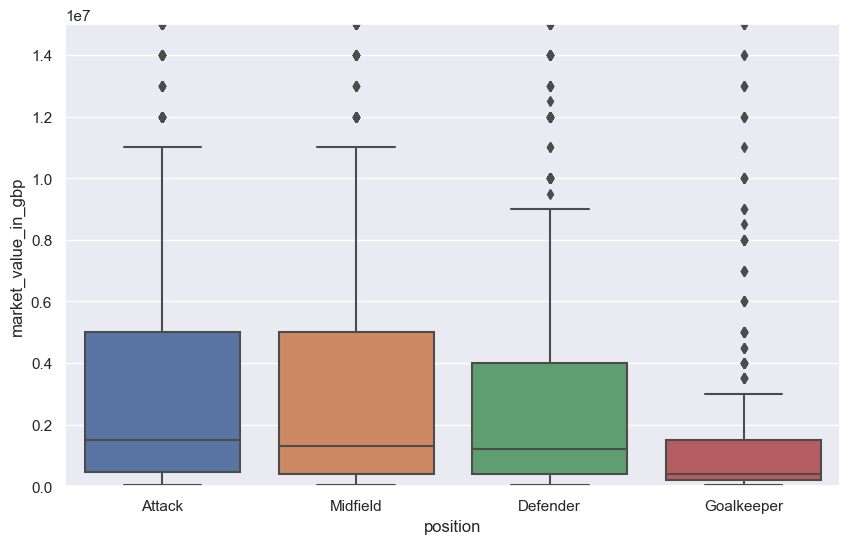

In [13]:
grupo2 = jugadores.loc[:,['position', 'market_value_in_gbp']] \
    .groupby(['position']) \
    .median() \
    .sort_values(by='market_value_in_gbp', ascending=False)

sns.set(rc={'figure.figsize':(10,6)})
plt.ylim(0, 15000000)
sns.boxplot(x=jugadores.position, y=jugadores.market_value_in_gbp, order=grupo2.index)

Valor de mercado por posición. 

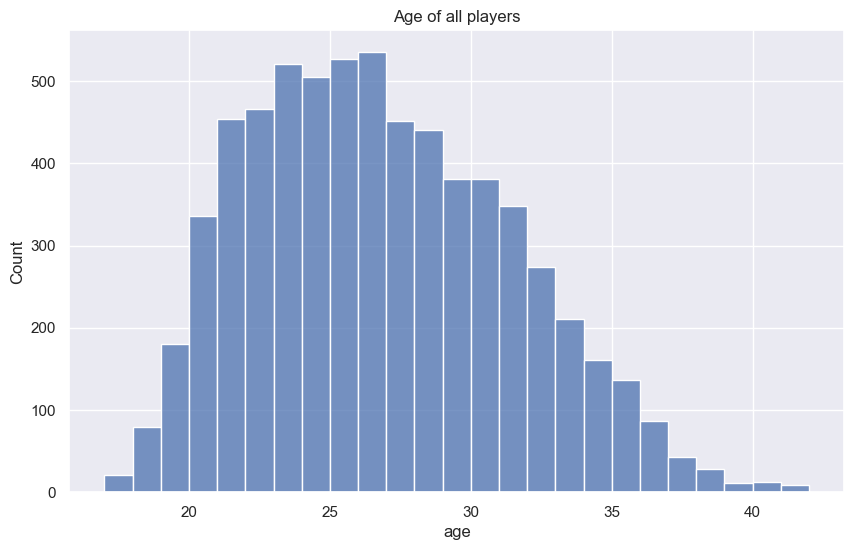

Mean player age :  26.330353083800574
Median player age :  26.0


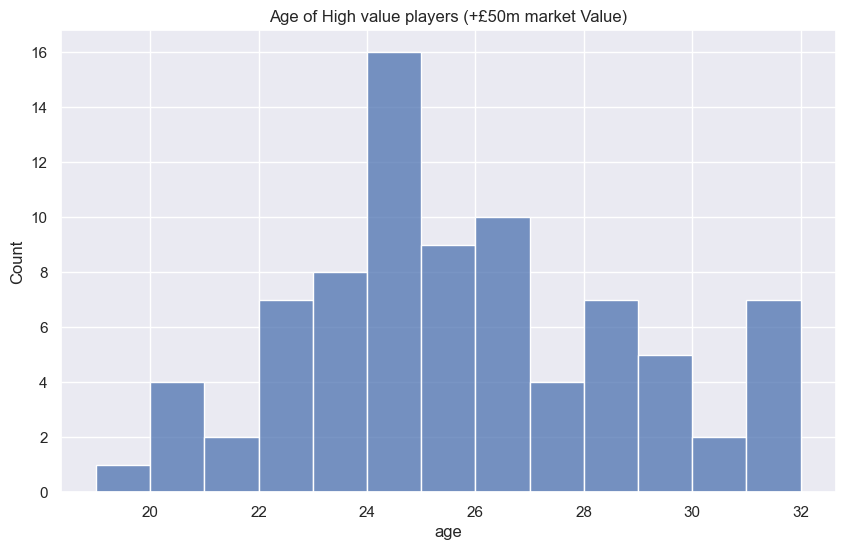

Mean player age (High value) :  25.304878048780488
Median player age (High value) :  25.0


In [14]:
plt.title("Age of all players")
sns.histplot(x='age',data=jugadores, binwidth=1)
plt.show()

print("Mean player age : ", jugadores['age'].mean())
print("Median player age : ", jugadores['age'].median())

High_value_players = jugadores[jugadores['market_value_in_gbp']>50000000]
plt.title("Age of High value players (+£50m market Value)")
sns.histplot(x='age',data=High_value_players, binwidth=1)
plt.show()

print("Mean player age (High value) : ", High_value_players['age'].mean())
print("Median player age (High value) : ", High_value_players['age'].median())

Edad de los jugadores y edad de los jugadores con 50 o mas millones de libras de valor de mercado. 

In [15]:
jugadores[['goals_2021','market_value_in_gbp']].corr()

,goals_2021,market_value_in_gbp
goals_2021,1.00000,0.45471
market_value_in_gbp,0.45471,1.00000


Goles marcados. Se observa que existe una correlación positiva entre el valor de mercado y los goles marcados.

In [18]:
jugadores[jugadores['position'] == 'Attack'][['goals_2021','market_value_in_gbp']].corr()

,goals_2021,market_value_in_gbp
goals_2021,1.000000,0.558174
market_value_in_gbp,0.558174,1.000000


Esta correlacion es mayor para los atacantes. 

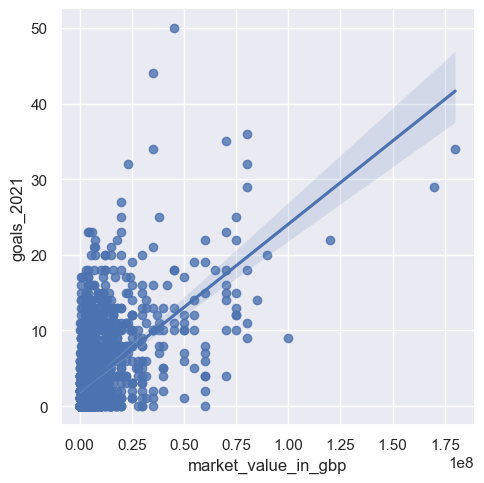

In [21]:
attackers = jugadores[jugadores['position'] == 'Attack']
sns.lmplot(x='market_value_in_gbp',y='goals_2021',data=attackers)

Portería a cero. Se observa una alta correlación con el valor de mercado de los porteros.

In [22]:
jugadores[jugadores['position'] == 'Goalkeeper'][['clean_sheet_2021','market_value_in_gbp']].corr()

,clean_sheet_2021,market_value_in_gbp
clean_sheet_2021,1.000000,0.584792
market_value_in_gbp,0.584792,1.000000
